In [226]:
from bs4 import BeautifulSoup
import requests
import urllib.request
from datetime import datetime
import pickle
import pandas as pd
import glob
import os
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [227]:
#parameters
project_folder = '/Users/alexiseggermont/Dropbox (Personal)/01. Personal/04. Models/30. Bike thieves must die/'
weekdays = {0:'1 - Monday',1:'2 - Tuesday',2:'3 - Wednesday',3:'4 - Thursday',4:'5 - Friday',5:'6 - Saturday',6:'7 - Sunday'}
distance = 100 #searches for bikes in that radius from your IP's location, in km
pagesToDownload = 5 #classified are ranked with most recently posted first. Each page contains 35 classifieds.
filename = 'list' #name of Excel and pickle file produced

In [228]:
def findAllItemsInPage(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    mydivs = soup.find_all('div', class_='listed-adv-item') 
    return mydivs

In [229]:
def getDateForOneItem(item):
    d={}
    d['observed_datetime'] = datetime.now().strftime('%Y-%m-%d %H:%M')
    d['data-adv-id'] = item.attrs['data-adv-id']
    d['data-adv-link'] = item.attrs['data-adv-link']
    img = item.find('img')
    d['price'] = item.find_all('div', class_='listed-item-price')[0].text
    d['description'] = item.find_all('p', class_='description')[0].text
    
    d['seller_link'] = item.find_all('a', class_='listed-adv-item-seller-link')[0].attrs['href']
    d['seller_name'] = item.find_all('a', class_='listed-adv-item-seller-link')[0].text.strip()
    d['listed_datetime'] = item.find_all('time', class_='listed-item-date')[0].attrs['datetime']
    d['address'] = item.find_all('address', class_='listed-item-place')[0].text.strip()
    filename = item.attrs['data-adv-id']+".jpg"
    if filename in not_suspect_ads:
        d['status'] = 'not suspect'
    elif filename in suspect_ads:
        d['status'] = 'suspect'
    else:
        d['status'] = 'not processed'

    try:
        img_link = img.attrs['src']
        if filename not in not_suspect_ads and filename not in suspect_ads:
            urllib.request.urlretrieve(img_link,  project_folder+'Photos/'+filename)
    except:
        img_link = 'no image'
    d['image_link'] = img_link

    return d

In [230]:
def savedata(filename):
    try:
        with open(project_folder+filename+'.pickle', 'wb') as fp:
            pickle.dump(ls, fp)
    except:
        pass
    df = pd.DataFrame(ls)
    df = df.sort_values('observed_datetime', ascending = False)
    df = df.drop_duplicates(subset = ['data-adv-id'], keep = 'first')
    df = df.sort_values('listed_datetime', ascending = False)
    df.to_excel(project_folder+filename+'.xlsx')
    print(str(len(df))+" bike ads downloaded overall")

In [231]:
not_suspect_ads = [] #Create a Not suspect folder where you can dump all pictures that you verified aren't your bike
os.chdir(project_folder+"Photos/Not_suspect/") #Create a Suspect folder where you can dump all pictures that look like your bike
for file in glob.glob("*.jpg"):
    not_suspect_ads.append(file)

suspect_ads = []
os.chdir(project_folder+"Photos/Suspect/")
for file in glob.glob("*.jpg"):
    not_suspect_ads.append(file)
    
with open (project_folder+'list.pickle', 'rb') as fp:
    ls = pickle.load(fp)
for i in range(pagesToDownload):
    url = 'https://www.2ememain.be/v%C3%A9los/?distance=110000&offset='+str(35*i)
    items = findAllItemsInPage(url)
    for item in items:
        try:
            d = getDateForOneItem(item)
            ls.append(d)
        except Exception as e:
            print('item failed')
            print(e)
            print(item)
savedata(filename)

13662 bike ads downloaded overall


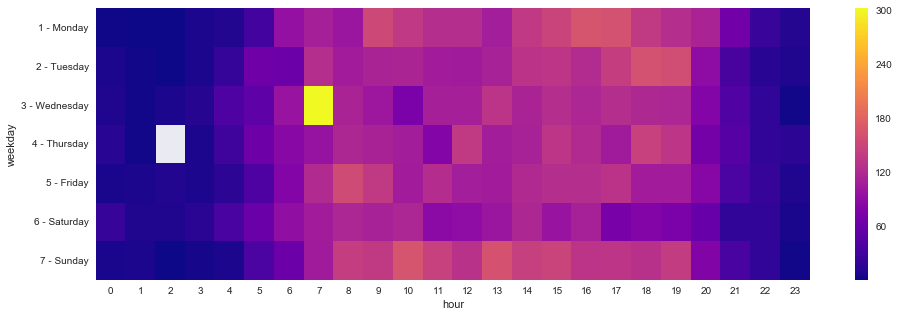

In [232]:
#Stats just for fun
df['listed_datetime'] = pd.to_datetime(df['listed_datetime'])
df['weekday'] = df['listed_datetime'].dt.weekday.map(weekdays)
df['hour'] = df['listed_datetime'].dt.hour
df_gb = df.groupby(['hour','weekday'], as_index=False).agg('count')
plt.figure(figsize = (16,5))
sns.heatmap(df_gb.pivot("weekday", "hour", "data-adv-id"), annot=False, cmap="plasma")

In [220]:
df

,address,data-adv-id,data-adv-link,datetime,description,image_link,listed_datetime,observed_datetime,price,seller_link,seller_name,status,weekday,hour
41598,Fernelmont Cortil-Wodon,adv-431041309,https://www.2ememain.be/v%C3%A9los/v%C3%A9los/...,NaN,Velo peu roulé car appartenait à mon fils mais...,https://img.2ememain.be/f/small/431041309.jpg,2018-06-09 06:48:16,2018-06-09 08:50:00,"€ 70,00",/profil/4060250/,Stephpl,not processed,6 - Saturday,6
41599,Beyne-Heusay,adv-431040808,https://www.2ememain.be/v%C3%A9los/v%C3%A9los/...,NaN,"VTT en parfait état , entièrement révisé en av...",https://img.2ememain.be/f/small/431040808.jpg,2018-06-09 06:44:57,2018-06-09 08:50:00,"€ 150,00",/profil/5469451/,loupette05,not processed,6 - Saturday,6
41600,Verviers,adv-431040753,https://www.2ememain.be/v%C3%A9los/pi%C3%A8ces...,NaN,Paire de roues vtt en bon état Roue avant Cres...,https://img.2ememain.be/f/small/431040753_1.jpg,2018-06-09 06:44:38,2018-06-09 08:50:00,"€ 150,00",/profil/7983568/,B.G,not processed,6 - Saturday,6
41601,Ecaussinnes Ecaussinnes-Lalaing,adv-431040269,https://www.2ememain.be/v%C3%A9los/v%C3%A9los/...,NaN,tricycle smoby baby bike 2 en métal pedalier c...,https://img.2ememain.be/f/small/431040269_1.jpg,2018-06-09 06:42:02,2018-06-09 08:50:00,"€ 20,00",/profil/4164029/,Pikaro,not processed,6 - Saturday,6
41602,Fernelmont Cortil-Wodon,adv-431040082,https://www.2ememain.be/v%C3%A9los/v%C3%A9los/...,NaN,Vélo enfant mixte. Style VTT. A vendre car ma ...,https://img.2ememain.be/f/small/431040082.jpg,2018-06-09 06:41:03,2018-06-09 08:50:00,"€ 30,00",/profil/4060250/,Stephpl,not processed,6 - Saturday,6
41603,Ottignies-Louvainla-Neuve Louvainla-Neuve,adv-431039892,https://www.2ememain.be/v%C3%A9los/v%C3%A9los/...,NaN,voir https://www.groupon.be/deals/gg-groupon-g...,https://img.2ememain.be/f/small/431039892.jpg,2018-06-09 06:39:39,2018-06-09 08:50:00,Prix à disc.,/profil/5484907/,Marco,not processed,6 - Saturday,6
41604,Fernelmont Cortil-Wodon,adv-431039681,https://www.2ememain.be/v%C3%A9los/v%C3%A9los/...,NaN,A vendre vélo en très bon état et entretenu. C...,https://img.2ememain.be/f/small/431039681.jpg,2018-06-09 06:38:13,2018-06-09 08:50:00,"€ 40,00",/profil/4060250/,Stephpl,not processed,6 - Saturday,6
41605,Rixensart Genval,adv-431039134,https://www.2ememain.be/v%C3%A9los/v%C3%A9los/...,NaN,"Vélo avec stabilisateurs, en bon état (1er pro...",https://img.2ememain.be/f/small/431039134.jpg,2018-06-09 06:33:58,2018-06-09 08:50:00,"€ 50,00",/profil/9162027/,Didier,not processed,6 - Saturday,6
41606,La Louvière,adv-431038698,https://www.2ememain.be/v%C3%A9los/v%C3%A9los/...,NaN,A vendre super Vélo Eddy Merckx EMX1 105T Mixt...,https://img.2ememain.be/f/small/431038698_1.jpg,2018-06-09 06:30:43,2018-06-09 08:50:00,"€ 950,00",/profil/2184214/,Lorenzo,not processed,6 - Saturday,6
41607,Soignies,adv-431038435,https://www.2ememain.be/v%C3%A9los/v%C3%A9los/...,NaN,VTT TREK X-Caliber 9 modèle 2018 Pour plus de ...,https://img.2ememain.be/f/small/431038435.jpg,2018-06-09 06:28:57,2018-06-09 08:50:00,"€ 1.000,00",/profil/774376/,Greg Tahon,not processed,6 - Saturday,6
